In [1]:
import csv
import datetime
import glob
import grequests
import io
import numpy as np
import os
import pandas as pd
import re
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager
import ssl
import time
import urllib.parse

When the user query page loads its table, it sends XHRs to https://jpwebsite.harriscountytx.gov/PublicExtracts/GetExtractData .

I set this routine up to use `grequests` (async) so I could fetch data in parallel. But (maybe just on Windows?) that led to very high rates of connection errors (SSL handshake failures), so I ended up cutting it down to 1-2 anyway.



*Update*: found a fix, which I'm bringing in from the other notebook.

In [5]:
# Work around some Windows TLS issues
class MyAdapter(HTTPAdapter):
    def init_poolmanager(self, connections, maxsize, block=False):
        self.poolmanager = PoolManager(num_pools=connections,
                                       maxsize=maxsize,
                                       block=block,
                                       ssl_version=ssl.PROTOCOL_TLSv1_2)

In [6]:
def makerequest(court, from_date, to_date, session):
    """Query the Houston Courts extract data service
    
    Returns a tuple of the header and the data"""
    return grequests.get(
        'https://jpwebsite.harriscountytx.gov/PublicExtracts/GetExtractData',
        params={
            'extractCaseType': 'CV', # Civil 
            'extract': 3, # Judgments entered
            'court': court,
            'casetype': 'EV', # Eviction
            'format': 'csv',
            'fdate': from_date.strftime('%m/%d/%Y'),
            'tdate': to_date.strftime('%m/%d/%Y'),
        },
        stream=False,
        session=session)

Retrying the failures worked fine, so this little exception handler (factory) makes it easy to keep track of them.

In [7]:
def makeexceptionhandler(eh_badreqs):
    """make an exception handler for a call to `grequests.map` that collects failed requests in the `eh_badreqs` list
    """
    def exceptionhandler(req, exc):
        print("Request failed:", str(exc), req.kwargs['params'])
        eh_badreqs.append(req.kwargs['params'])
    return exceptionhandler

And a helper to make adequately unique CSV file names

In [8]:
def urltocsvpath(template, url):
    """Parse the court and from-data from an API URL and use it to make a distinct CSV file name.
    """
    pr = urllib.parse.parse_qs(url)
    return template.format(
        pr['court'][0],
        re.sub('^(..)/(..)/(.+)$',r'\3-\1-\2', pr['fdate'][0]))

In [10]:
# interactive sanity check
req = makerequest(305, datetime.date(2016,1,1), datetime.date(2016,1,31), None)
r = grequests.map([req])

In [11]:
# interactive sanity check
r[0].status_code

200

In [14]:
# interactive sanity check
urltocsvpath('tmp/tmp_court_{}-{}.csv', r[0].request.url)

'tmp/tmp_court_305-2016-01-01.csv'

Most of the actual control flow lives here; this sends the requests passed in via iterable `reqs` and write outputs to filenames generated using the routine above, and retries any failures.

In [15]:
def send_requests(reqs, size=5, template='tmp/tmp_court_{}-{}.csv'):
    eh_badreqs = True # hokey trick to bootstrap first loop iteration
    while eh_badreqs:
        eh_badreqs = []
        exceptionhandler = makeexceptionhandler(eh_badreqs)
        for resp in grequests.imap(reqs, exception_handler=exceptionhandler, size=size):
            if resp.status_code == 200:
                with open(urltocsvpath(template, resp.request.url), 'w') as out:
                    out.write(resp.text.replace('\n\n','\n'))
            else:
                print("Request failed:", req.kwargs['params'])
        print("\n\n*** Retrying", len(eh_badreqs), "bad requests")
        reqs = []
        for params in eh_badreqs:
            reqs.append(grequests.get('https://jpwebsite.harriscountytx.gov/PublicExtracts/GetExtractData', params=params))

A few date manipulation routines to get month start/end dates for queries.

In [16]:
def incmonth(date):
    """Returns a `datetime.date` fo the first day of the month after the input date's month.
    """
    if date.month < 12:
        return datetime.date(date.year, date.month+1, date.day)
    else:
        return datetime.date(date.year+1, 1, date.day)

In [17]:
def endofmonth(date):
    """Returns a `datetime.date` for the last day of the input date's month
    """
    return incmonth(datetime.date(date.year, date.month, 1)) - datetime.timedelta(1)

In [18]:
def datebounds(
    start=datetime.date(2011,1,1),
    limit=datetime.datetime.now().date()
):
    """Generator to  yield month startdate-enddate pairs contained in the range [start, limit).
    The first pair will always start with `begin`, so may be less than a full month.
    The last pair will always be for the month before `end`'s month.
    """
    fromdate = start
    todate = endofmonth(fromdate)
    while fromdate < limit and todate < limit:
        yield (fromdate, todate)
        fromdate = incmonth(fromdate)
        todate = endofmonth(fromdate)

In [19]:
# interactive sanity check
[x for x in datebounds(datetime.date(2017,1,1))]

[(datetime.date(2017, 1, 1), datetime.date(2017, 1, 31)),
 (datetime.date(2017, 2, 1), datetime.date(2017, 2, 28)),
 (datetime.date(2017, 3, 1), datetime.date(2017, 3, 31)),
 (datetime.date(2017, 4, 1), datetime.date(2017, 4, 30)),
 (datetime.date(2017, 5, 1), datetime.date(2017, 5, 31))]

So putting them together, we can make a generator to 

In [20]:
def makerequests(session):
    for frm,to in datebounds():
        for court in [305, # Precinct 1, Place 1
                      310, # Precinct 1, Place 2
                      315, # Precinct 2, Place 1
                      320, # Precinct 2, Place 2
                      325, # Precinct 3, Place 1
                      330, # Precinct 3, Place 2
                      335, # Precinct 4, Place 1
                      340, # Precinct 4, Place 2
                      345, # Precinct 5, Place 1
                      350, # Precinct 5, Place 2
                      355, # Precinct 6, Place 1
                      360, # Precinct 6, Place 2
                      365, # Precinct 7, Place 1
                      370, # Precinct 7, Place 2
                      375, # Precinct 8, Place 1
                      380, # Precinct 8, Place 2
                     ]:
            yield makerequest(court, frm, to, session)

In [22]:
try:
    os.mkdir('tmp')
except:
    pass

In [23]:
%%time
s = requests.Session()
s.mount('https://', MyAdapter())
send_requests(makerequests(s), size=5, template='tmp/tmp_court_{}-{}.csv')



*** Retrying 0 bad requests
Wall time: 12min 15s


Concatenate the temporary files

In [2]:
fns = glob.glob('tmp/tmp_c*.csv')
wrote_hdr = False
with open('evictions-20170431.csv', 'w') as out:
    for fn in fns:
        with open(fn) as f:
            hdr = f.readline()
            if not wrote_hdr:
                out.write(hdr)
                wrote_hdr = True
            out.write(f.read())

And load them into a `DataFrame`...

In [5]:
df = pd.read_csv('evictions-20170431.csv')

S:\programs\x64\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2683: DtypeWarning: Columns (5,31,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,56,57,58,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Argh! bad rows.  How many are there?

In [6]:
import itertools
from pprint import pprint
pr = 70
for fn in glob.glob('tmp/tmp_c*.csv'):
    with open(fn) as f:
        rdr = csv.reader(f)
        hdr = next(rdr)
        if pr != len(hdr):
            print("Cols changed from {} to {} for {}".format(
                pr,
                len(hdr),
                fn
            ))
        pr = len(hdr)
        for row in rdr:
            if len(row) and len(row) != len(hdr):
                print('Got {} cols instead of {} at\t vi +{} {}'.format(
                    len(row),
                    len(hdr),
                    rdr.line_num,
                    fn
                ))
                pprint(list(itertools.zip_longest(hdr,row, fillvalue='')))
                print()

We can omit these 39 by adding `error_bad_lines=False` to the `read_csv` arguments, but cleanin them up isn't too bad -- these are unescaped double quotes in defendant and plaintiff names, generally identifiable by the pattern  
`/[^,"]"[^,"]+"[^,"]/`

In [ ]:
!perl -pi -e 's/([^,"])("[^,"]+")([^,"])/\1"\2"\3/g'  `egrep -l '[^,"]"[^,"]+"[^,"]' tmp/tmp_court_*.csv

In [2]:
fns = glob.glob('tmp/tmp_c*.csv')
wrote_hdr = False
with open('evictions-20170431.csv', 'w') as out:
    for fn in fns:
        with open(fn) as f:
            hdr = f.readline()
            if not wrote_hdr:
                out.write(hdr)
                wrote_hdr = True
            out.write(f.read())

In [17]:
df = pd.read_csv('evictions-20170431.csv', error_bad_lines=False)

S:\programs\x64\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2683: DtypeWarning: Columns (5,31,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,56,57,58,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
df.columns[[5,31,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,56,57,58,65,66,67,68]]

Index(['Nature of Claim ', 'Defendant Atty ZIP 1', 'Second Plaintiff Name',
       'Second Plaintiff Addr Line 1 ', 'Second Plaintiff Addr Line 2',
       'Second Plaintiff Addr City ', 'Second Plaintiff Addr State',
       'Second Plaintiff Addr ZIP 1', 'Second Plaintiff Atty Name ',
       'Second Plaintiff Atty Addr 1 ', 'Second Plaintiff Atty Addr 2 ',
       'Second Plaintiff Atty City ', 'Second Plaintiff Atty State',
       'Second Plaintiff Atty ZIP 1', 'Second Defendant Atty Name',
       'Second Defendant Atty Addr 1', 'Second Defendant Atty Addr 2',
       'Second Defendant Atty City', 'Second Defendant Atty State ',
       'Second Defendant Atty ZIP 1 ', 'Next Hearing Desc',
       'Next Hearing Date', 'Next Hearing Time', 'Judgment Amount',
       'Attorney Fees', 'Court Costs', 'Pre-Judg Int Rate'],
      dtype='object')

Whoops, let's trim those column names' stray trailing spaces, and change the remaining spaces to dots

In [20]:
df.columns = df.columns.str.replace(' $','').str.replace(' ','.')

In [21]:
df.shape

(207817, 70)

In [29]:
df.describe()

,Judgment.Amount,Attorney.Fees,Court.Costs,Pre-Judg.Int.Rate
count,207814.000000,207815.000000,207815.000000,207815.000000
mean,1101.093536,10.983601,103.843637,0.015911
std,2071.005644,126.553802,543.651985,2.997813
min,0.000000,0.000000,0.000000,0.000000
25%,231.000000,0.000000,101.000000,0.000000
50%,875.000000,0.000000,111.000000,0.000000
75%,1492.000000,0.000000,116.000000,0.000000
max,700337.000000,10000.000000,110613.000000,1225.000000


In [6]:
def date_opt(val):
    try:
        return pd.to_datetime(val)
    except ValueError:
        pass
def time_opt(val):
    try:
        return pd.Timedelta(val)
    except ValueError:
        pass
def float_opt(val):
    try:
        return float(val)
    except ValueError:
        return float('nan')

In [27]:
%%time
df = pd.read_csv(
    'evictions-20170431.csv',
    error_bad_lines=False,
    converters={
        'Case.File.Date':	date_opt,
        'Claim.Amount':	float_opt,
        'Plaintiff.Addr.ZIP.1':	str,
        'Plaintiff.Atty.ZIP.1':	str,
        'Defendant.Addr.ZIP.1':	str,
        'Defendant.Atty.ZIP.1':	str,
        'Second.Plaintiff.Addr.ZIP.1':	str,
        'Second.Plaintiff.Atty.ZIP.1':	str,
        'Second.Defendant.Addr.ZIP.1':	str,
        'Second.Defendant.Atty.ZIP.1':	str,
        'Next.Hearing.Date':	date_opt,
        'Next.Hearing.Time':	time_opt,
        'Disposition.Date':	date_opt,
        'Judgment.Date':	date_opt,
        'Judgment.Amount':	float_opt,
        'Attorney.Fees':	float_opt,
        'Court.Costs':	float_opt,
        'Pre-Judg.Int.Rate':	float_opt,
        'Post-Judg.Int.Rate':	float_opt,
    },
    names=df.columns,
    skiprows=1
)

<string>:2: DtypeWarning: Columns (5,6,32,33,34,35,36,38,39,40,41,42,50,51,52,53,54,56,69) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 3min 9s


Oh, let's fix the dtypes for fun

In [31]:
from collections import Counter
Counter(df.loc[:,'Disposition.Desc'])

Counter({nan: 139426,
         'Non-suited or Dismissed by Plaintiff (OCA)': 87,
         'All Other Dispositions Except Dismissal (OCA)': 2,
         'Dismissed for Want of Prosecution (OCA)': 54,
         'All Other Dispositions (OCA)': 2910,
         'Trial or Hearing by Judge (OCA)': 24502,
         'Trial by Jury (OCA)': 42,
         'Default Judgment (OCA)': 40157,
         'Agreed Judgment (OCA)': 637})

In [33]:
pd.options.display.max_rows = None
df2.apply(lambda x: x.apply(lambda y: isinstance(y,str) and len(y) or 0), axis=0).max(axis=0)

Unnamed: 0                        0
Case.Number                      12
Case.Type                         2
Case.Subtype                      8
Case.File.Date                    0
Style.Of.Case                   383
Nature.of.Claim                  38
Claim.Amount                      0
Case.Status                      10
Plaintiff.Name                  298
Plaintiff.Addr.Line.1            53
Plaintiff.Addr.Line.2            26
Plaintiff.Addr.City              20
Plaintiff.Addr.State              2
Plaintiff.Addr.ZIP.1             10
Plaintiff.Atty.Name              31
Plaintiff.Atty.Addr.1            38
Plaintiff.Atty.Addr.2            25
Plaintiff.Atty.City              15
Plaintiff.Atty.State              7
Plaintiff.Atty.ZIP.1             10
Defendant.Name                  145
Defendant.Addr.Line.1            64
Defendant.Addr.Line.2            39
Defendant.Addr.City              16
Defendant.Addr.State              7
Defendant.Addr.ZIP.1             10
Defendant.Atty.Name         

In [23]:
%%time
df2 = pd.read_csv(
    'evictions-20170431-clean.csv',
    dtype = {
        'Case.Number': np.str,
        'Case.Type': np.str,
        'Case.Subtype': np.str,
        'Style.Of.Case': np.str,
        'Nature.of.Claim': np.str,
        'Case.Status': np.str,
        'Plaintiff.Name': np.str,
        'Plaintiff.Addr.Line.1': np.str,
        'Plaintiff.Addr.Line.2': np.str,
        'Plaintiff.Addr.City': np.str,
        'Plaintiff.Addr.State': np.str,
        'Plaintiff.Addr.ZIP.1': np.str,
        'Plaintiff.Atty.Name': np.str,
        'Plaintiff.Atty.Addr.1': np.str,
        'Plaintiff.Atty.Addr.2': np.str,
        'Plaintiff.Atty.City': np.str,
        'Plaintiff.Atty.State': np.str,
        'Plaintiff.Atty.ZIP.1': np.str,
        'Defendant.Name': np.str,
        'Defendant.Addr.Line.1': np.str,
        'Defendant.Addr.Line.2': np.str,
        'Defendant.Addr.City': np.str,
        'Defendant.Addr.State': np.str,
        'Defendant.Addr.ZIP.1': np.str,
        'Defendant.Atty.Name': np.str,
        'Defendant.Atty.Addr.1': np.str,
        'Defendant.Atty.Addr.2': np.str,
        'Defendant.Atty.City': np.str,
        'Defendant.Atty.State': np.str,
        'Defendant.Atty.ZIP.1': np.str,
        'Second.Plaintiff.Name': np.str,
        'Second.Plaintiff.Addr.Line.1': np.str,
        'Second.Plaintiff.Addr.Line.2': np.str,
        'Second.Plaintiff.Addr.City': np.str,
        'Second.Plaintiff.Addr.State': np.str,
        'Second.Plaintiff.Addr.ZIP.1': np.str,
        'Second.Plaintiff.Atty.Name': np.str,
        'Second.Plaintiff.Atty.Addr.1': np.str,
        'Second.Plaintiff.Atty.Addr.2': np.str,
        'Second.Plaintiff.Atty.City': np.str,
        'Second.Plaintiff.Atty.State': np.str,
        'Second.Plaintiff.Atty.ZIP.1': np.str,
        'Second.Defendant.Name': np.str,
        'Second.Defendant.Addr.Line.1': np.str,
        'Second.Defendant.Addr.Line.2': np.str,
        'Second.Defendant.Addr.City': np.str,
        'Second.Defendant.Addr.State': np.str,
        'Second.Defendant.Addr.ZIP.1': np.str,
        'Second.Defendant.Atty.Name': np.str,
        'Second.Defendant.Atty.Addr.1': np.str,
        'Second.Defendant.Atty.Addr.2': np.str,
        'Second.Defendant.Atty.City': np.str,
        'Second.Defendant.Atty.State': np.str,
        'Second.Defendant.Atty.ZIP.1': np.str,
        'Next.Hearing.Desc': np.str,
        'Disposition.Desc': np.str,
        'Judgment.Text': np.str,
        'Judgment.In.Favor.Of': np.str,
        'Judgment.Against': np.str
    },
    converters = {
        'Case.File.Date': date_opt,
        'Claim.Amount': float_opt,
        'Next.Hearing.Date': date_opt,
        'Next.Hearing.Time': time_opt,
        'Disposition.Date': date_opt,
        'Judgment.Date': date_opt,
        'Judgment.Amount': float_opt,
        'Attorney.Fees': float_opt,
        'Court.Costs': float_opt,
        'Pre-Judg.Int.Rate': float_opt,
        'Post-Judg.Int.Rate': float_opt
    }
)

Wall time: 1min 14s


In [8]:
if 'Unnamed: 0' in df2.columns:
    df2.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
df2.to_csv('evictions-20170431-final.csv', encoding='utf-8')

In [78]:
(df2['Judgment.In.Favor.Of'] == df2['Plaintiff.Name']).sum()

205152

In [79]:
(df2['Judgment.In.Favor.Of'] != df2['Plaintiff.Name']).sum()

2665

In [89]:
out=df2.loc[
    df2['Judgment.In.Favor.Of'] == df2['Plaintiff.Name'],
        ['Case.File.Date',
         'Judgment.Amount',
         'Defendant.Addr.Line.1', 'Defendant.Addr.City', 'Defendant.Addr.ZIP.1']]

In [ ]:
year=out['Case.File.Date'].dt.year
quarter=out['Case.File.Date'].dt.quarter


<IPython.core.display.Javascript object>


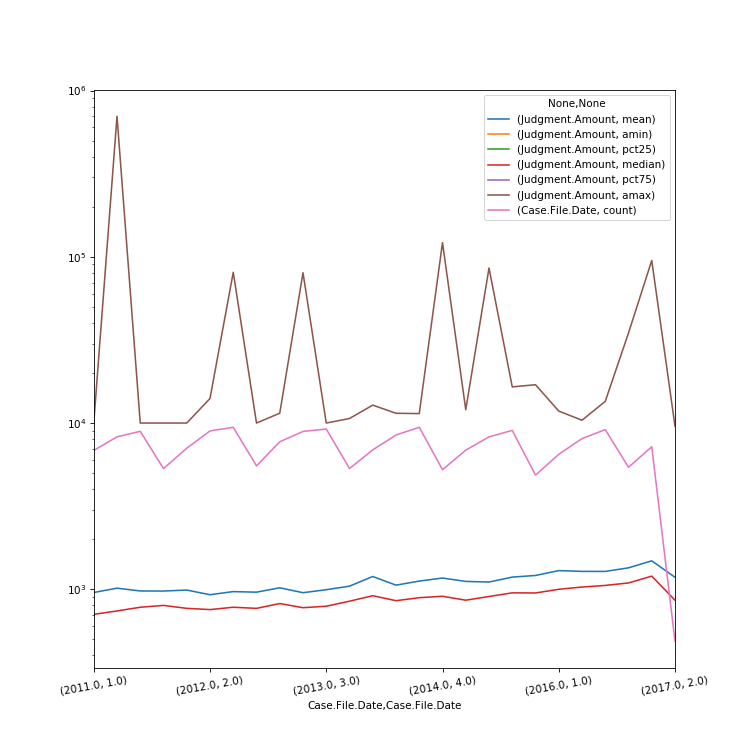

[]

In [151]:
%matplotlib notebook
import matplotlib.pyplot as plt

def pct25(x): x.dropna().quantile(.25)
def pct75(x): x.dropna().quantile(.75)
byquarter=out[year>2010].groupby([year,quarter]).agg({'Case.File.Date': pd.Series.count,
                                            'Judgment.Amount': (np.mean,
                                                                np.min,
                                                                pct25,
                                                                np.median,
                                                                pct75,
                                                                np.max,
                                                               )})
byquarter.plot(rot=10, figsize=(10,10))
plt.semilogy()

In [ ]:
out.loc[:100,'Judgment.Amount'].groupby(year[:100]).agg(quantile)

In [88]:
out.groupby('Year').count()

,Case.File.Date,Defendant.Addr.Line.1,Defendant.Addr.City,Defendant.Addr.ZIP.1
Year,,,,
1994.0,1,1,1,1
1997.0,1,1,1,1
1998.0,4,4,4,4
1999.0,1,1,1,1
2000.0,10,10,10,10
2001.0,5,5,5,5
2002.0,25,25,25,25
2003.0,8,8,8,8
2004.0,1,1,1,1


In [83]:
out.shape

(205152, 4)

In [58]:
pd.read_csv('evictions.csv')['Disposition.Date.'].count()

S:\programs\x64\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2683: DtypeWarning: Columns (25,40,48,50,57,58,59,60,61,73,76,77,78,79,80,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


8799

In [59]:
68391/8799

7.772587794067507